# Intro

## Requirements

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Autoreload allows the notebook to dynamically load code: if we update some helper functions outside of the notebook, we do not need to reload the notebook.
%load_ext autoreload
%autoreload 2

# All auxiliary code is in ../src
# code taken from: https://github.com/data-mining-UniPI/teaching24/tree/main/src
import sys
sys.path.append("./src/")

# Set style for seaborn
sns.set_theme(style="darkgrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import pickle

# Import the object using pickle
with open('prediction_datasets.pkl', 'rb') as f:
    sets = pickle.load(f)

print("Data has been imported from prediction_datasets.pkl")

Data has been imported from prediction_datasets.pkl
The datasets are:
train_set
train_labels
validation_set
validation_labels
test_set
test_labels
train_set_scaled
validation_set_scaled
test_set_scaled


In [54]:

print("The datasets contained in the variable are:")
for key in sets:
    print(key)

The datasets contained in the variable are:
train_set
train_labels
validation_set
validation_labels
test_set
test_labels
train_set_scaled
validation_set_scaled
test_set_scaled
train_set_scaled_sliced
validation_set_scaled_sliced
train_labels_sliced
validation_labels_sliced


## Setting up the models

We use the models selected in the previous task.

In [12]:
from sklearn import tree

with open('best_decision_tree_model.pkl', 'rb') as f:
    dt = pickle.load(f)

print("Decision tree model has been imported from best_decision_tree_model.pkl")
print(dt)

Decision tree model has been imported from best_decision_tree_model.pkl
DecisionTreeClassifier(max_depth=7, min_samples_leaf=4, min_samples_split=4)


In [13]:
from tensorflow.keras.models import load_model

# Load the Keras model using the native Keras format
keras_model = load_model('keras_model.keras')
print("Keras model has been imported from keras_model.keras")

Keras model has been imported from keras_model.keras


# Feature Importance: tree model

In [14]:
import shap

# Create the SHAP explainer
shap_explainer = shap.TreeExplainer(
    model=dt,
    data=sets['train_set'].astype('float64') # TODO: non usare data?
)

# Generate SHAP values
shap_explanations = shap_explainer(sets['validation_set'].astype('float64'))

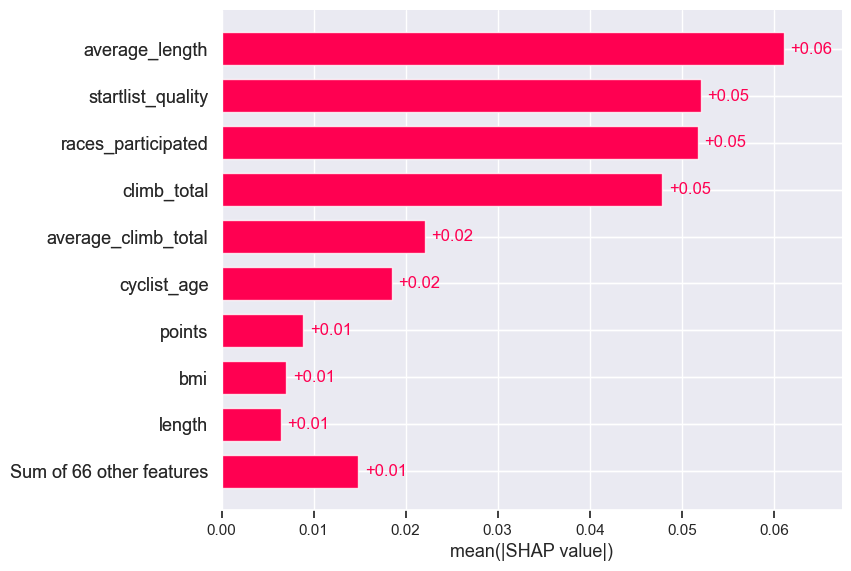

In [15]:
shap.plots.bar(shap_explanations[..., 1], max_display=10)

## SHAP Summary Plot Analysis

This SHAP summary plot explains how different features impact the model's prediction of whether a cyclist will finish in the top-20 for a race. 

- **`average_length`**: Longer races tend to lower the likelihood of a cyclist finishing in the top-20, as indicated by the negative SHAP values for high `average_length`.
- **`startlist_quality`**: Higher quality start lists slightly increase the chances of finishing in the top-20, suggesting that stronger competition positively influences the outcome.
- **`races_participated`**: Cyclists who participate in more races are less likely to finish in the top-20, possibly due to fatigue or accumulated stress.
- **`climb_total`**: Higher total climbs reduce the probability of finishing in the top-20, indicating that tougher, more mountainous races negatively impact performance.
- **`cyclist_age`**: Younger cyclists have a higher likelihood of finishing in the top-20, as seen by the positive SHAP values for lower ages.

This analysis provides insights into which features are most influential in the model's predictions and how they contribute to the decision-making process.

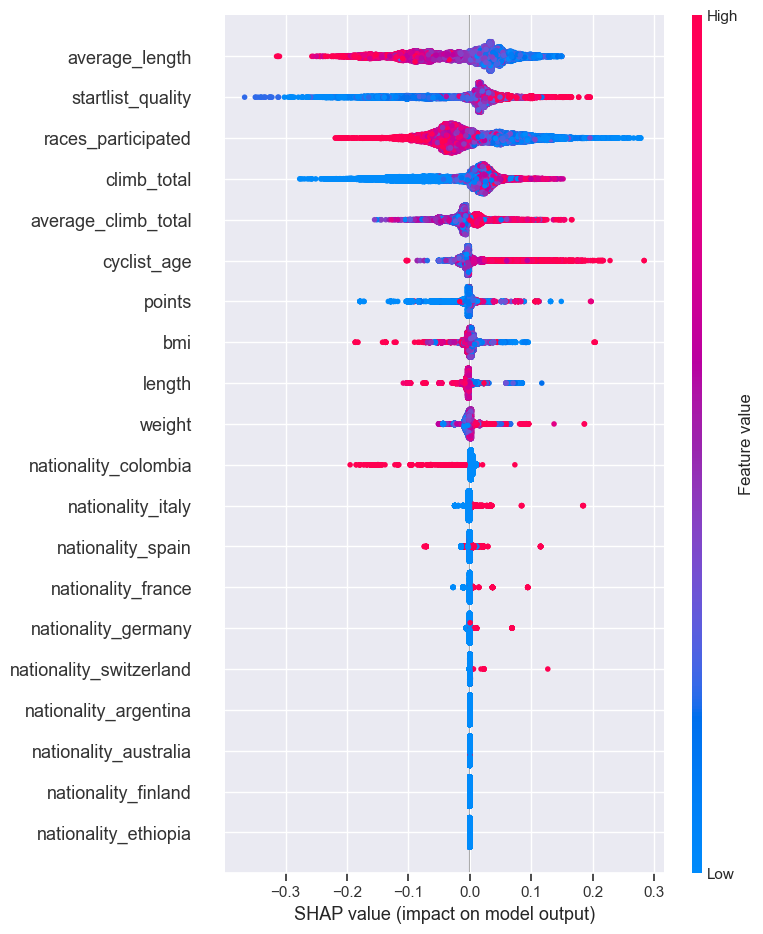

In [16]:

# Summary plot for the first class
shap.summary_plot(shap_explanations.values[:, :, 0], sets['validation_set'].astype('float64'))



## Examples on instances: SHAP Waterfall Plot Analysis

Here we analyze a specific instance to understand how different features contribute to the model's prediction for that instance.

This SHAP waterfall plot illustrates how each feature contributes to the model's prediction of whether a cyclist will finish in the top-20 for this specific race.

- **`average_length`**: With a SHAP value of -0.22, the long race distance (179855 meters) significantly decreases the likelihood of a top-20 finish.
- **`startlist_quality`**: A high-quality start list (594) further reduces the prediction by -0.15.
- **`races_participated`**: The cyclist's high participation in races (175) lowers the prediction by -0.07, suggesting potential fatigue.
- **`cyclist_age`**: The cyclist's age (28 years) slightly decreases the prediction by -0.02.
- **`average_climb_total`**: A high average climb total (2154 meters) contributes positively with a SHAP value of +0.02, indicating the cyclist might perform well in hilly races.
- Other features like `bmi`, `climb_total`, and `points` have smaller impacts, contributing either positively or negatively to the final prediction.

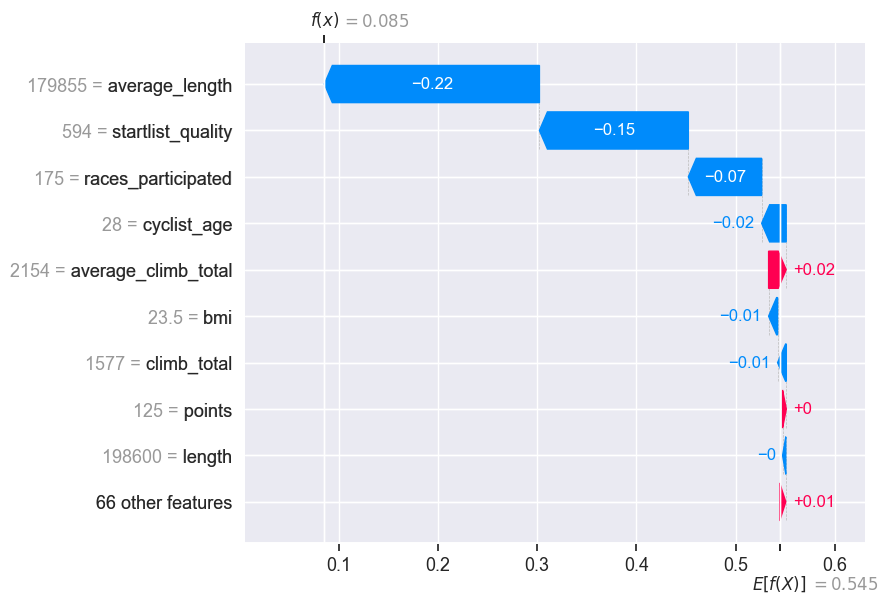

In [17]:
# Waterfall plot for the first instance and first class
shap.plots.waterfall(shap.Explanation(values=shap_explanations.values[0, :, 0], 
                                      base_values=shap_explanations.base_values[0, 0], 
                                      data=sets['validation_set'].astype('float64').iloc[0]))

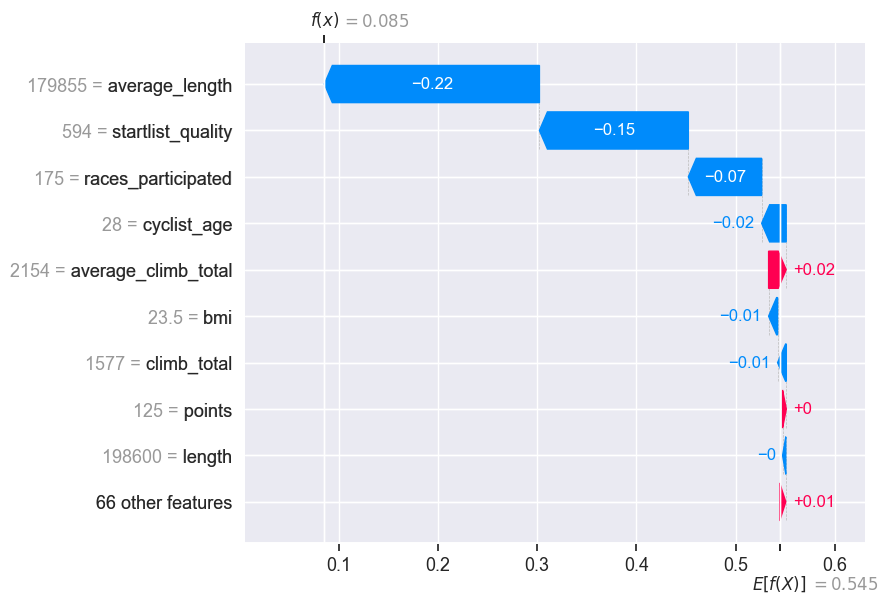

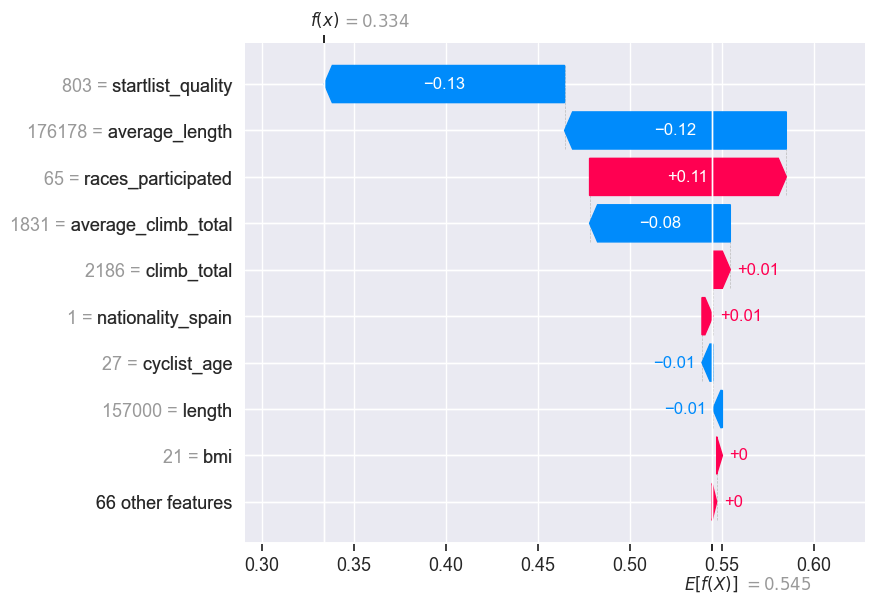

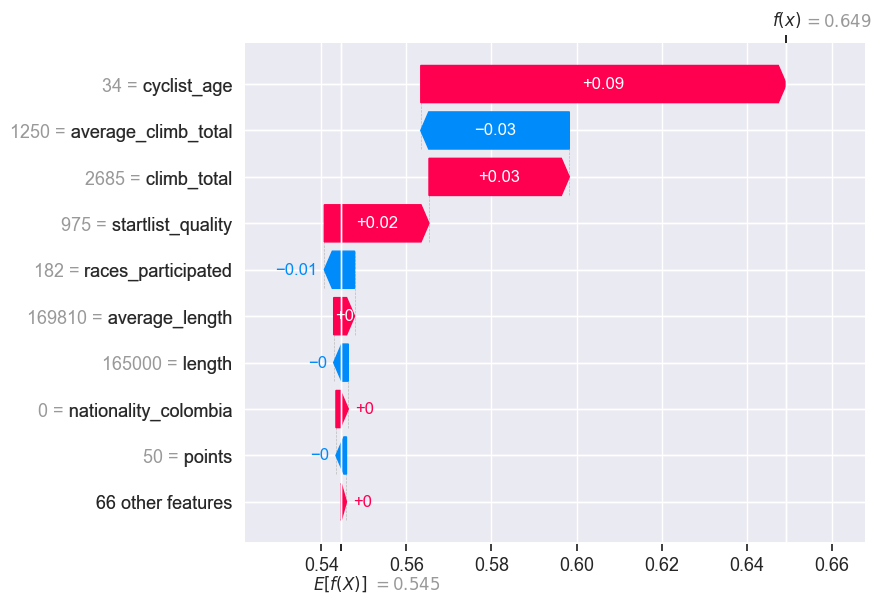

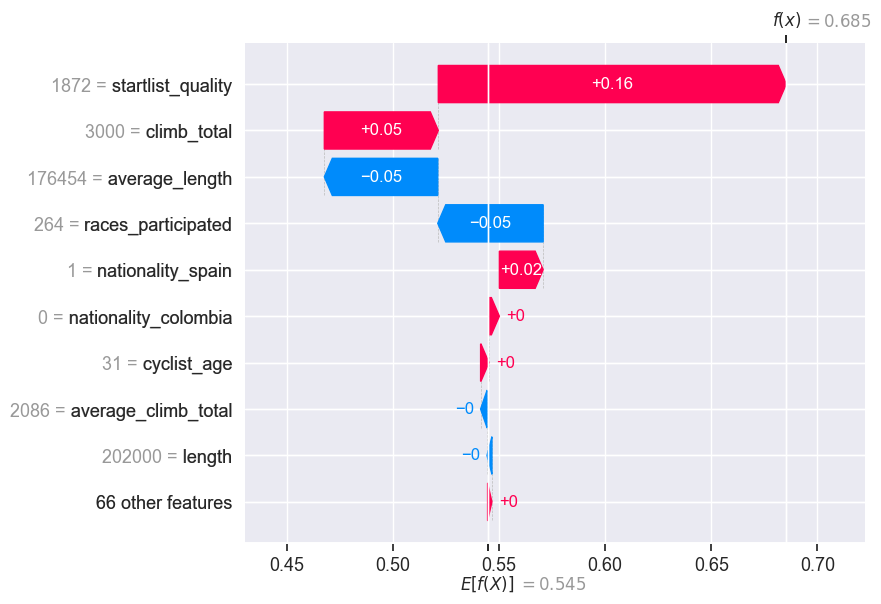

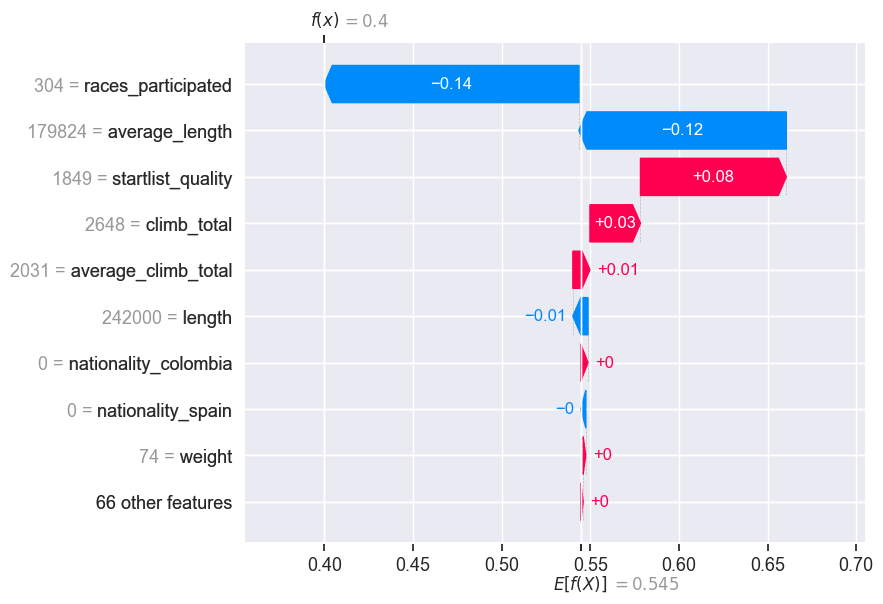

In [18]:
# Number of instances to plot
num_instances = 5  # Adjust this number as needed

# Loop through the instances and create waterfall plots
for i in range(num_instances):
    shap.plots.waterfall(shap.Explanation(values=shap_explanations.values[i, :, 0], 
                                          base_values=shap_explanations.base_values[i, 0], 
                                          data=sets['validation_set'].astype('float64').iloc[i]))
    plt.show()

# Feature Importance: neural network model

In [30]:
import shap

shap.initjs()

K = 100  # Number of samples
train_set_scaled_sampled = shap.sample(sets['train_set_scaled'].astype('float64'), K)

# Create the SHAP explainer
shap_explainer = shap.KernelExplainer(keras_model.predict, train_set_scaled_sampled)

# Generate SHAP values
validation_set_scaled_sampled = shap.sample(sets['validation_set_scaled'].astype('float64'), K)
shap_explanations = shap_explainer(validation_set_scaled_sampled)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6619/6619 ━━━━━━━━━━━━━━━━━━━━ 2s 247us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6619/6619 ━━━━━━━━━━━━━━━━━━━━ 2s 227us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6619/6619 ━━━━━━━━━━━━━━━━━━━━ 2s 254us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6619/6619 ━━━━━━━━━━━━━━━━━━━━ 2s 227us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6619/6619 ━━━━━━━━━━━━━━━━━━━━ 2s 229us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6619/6619 ━━━━━━━━━━━━━━━━━━━━ 2s 241us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6619/6619 ━━━━━━━━━━━━━━━━━━━━ 2s 245us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6619/6619 ━━━━━━━━━━━━━━━━━━━━ 2s 227us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6625/6625 ━━━━━━━━━━━━━━━━━━━━ 2s 227us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6619/6619 ━━━━━━━━━━━━━━━━━━━━ 2s 236us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6619/6619 ━━━━━━━━━━━━━━━━━━━━ 2s 227us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6619/6619 ━━━━━━━━━━━━━━━━━━━━ 2s 226us/step
1/1 

In [31]:
shap_explanations

.values =
array([[[ 0.00796545],
        [-0.01526394],
        [-0.02237282],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       [[-0.0199732 ],
        [-0.01383971],
        [-0.03119943],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       [[ 0.00229626],
        [-0.00776006],
        [-0.02060346],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       ...,

       [[ 0.01019212],
        [ 0.01799649],
        [-0.02055826],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       [[ 0.01451829],
        [-0.00233072],
        [ 0.03587091],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       [[ 0.01061799],
        [-0.01472244],
        [-0.03328604],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]]])

.base_values =
array([[0.47456511],
       [0.47456511],
 

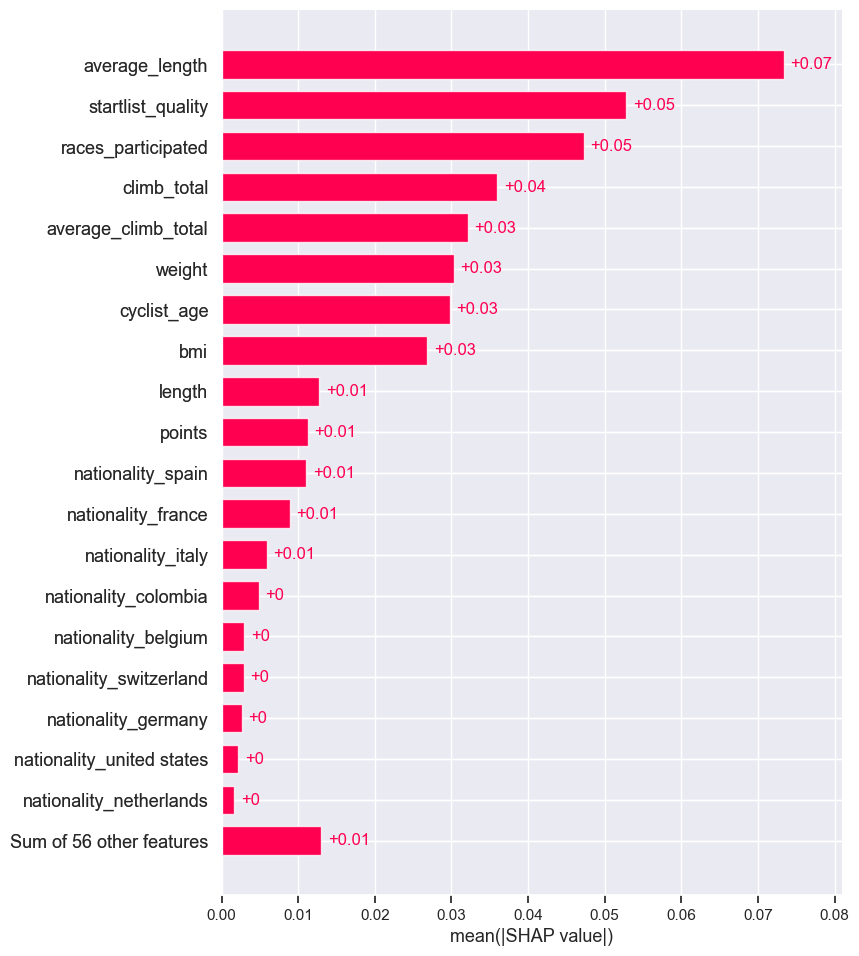

In [40]:
shap.plots.bar(shap_explanations[..., 0], max_display=20)

## SHAP Summary Plot Analysis

This SHAP summary plot explains how different features impact the model's prediction of whether a cyclist will finish in the top-20 for a race. 

- **`average_length`**: Longer races tend to lower the likelihood of a cyclist finishing in the top-20, as indicated by the negative SHAP values for high `average_length`.
- **`startlist_quality`**: Higher quality start lists slightly increase the chances of finishing in the top-20, suggesting that stronger competition positively influences the outcome.
- **`races_participated`**: Cyclists who participate in more races are less likely to finish in the top-20, possibly due to fatigue or accumulated stress.
- **`climb_total`**: Higher total climbs reduce the probability of finishing in the top-20, indicating that tougher, more mountainous races negatively impact performance.
- **`cyclist_age`**: Younger cyclists have a higher likelihood of finishing in the top-20, as seen by the positive SHAP values for lower ages.

This analysis provides insights into which features are most influential in the model's predictions and how they contribute to the decision-making process.

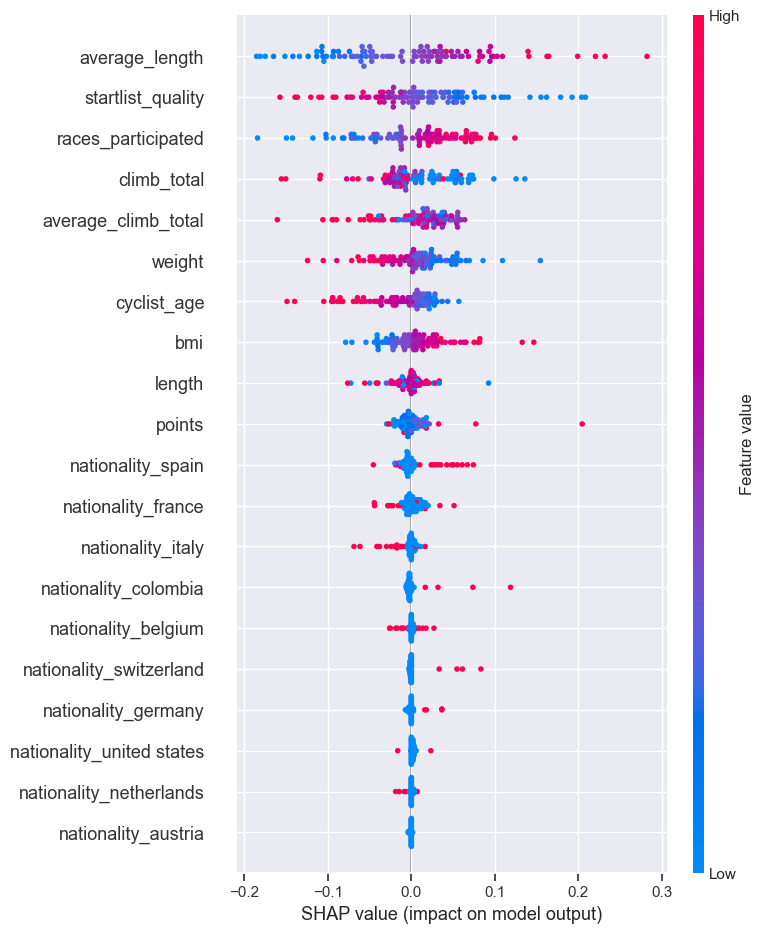

In [41]:

# Summary plot for the first class
shap.summary_plot(shap_explanations.values[:, :, 0], validation_set_scaled_sampled)



## Examples on instances: SHAP Waterfall Plot Analysis

Here we analyze a specific instance to understand how different features contribute to the model's prediction for that instance.

This SHAP waterfall plot illustrates how each feature contributes to the model's prediction of whether a cyclist will finish in the top-20 for this specific race.

- **`average_length`**: With a SHAP value of -0.22, the long race distance (179855 meters) significantly decreases the likelihood of a top-20 finish.
- **`startlist_quality`**: A high-quality start list (594) further reduces the prediction by -0.15.
- **`races_participated`**: The cyclist's high participation in races (175) lowers the prediction by -0.07, suggesting potential fatigue.
- **`cyclist_age`**: The cyclist's age (28 years) slightly decreases the prediction by -0.02.
- **`average_climb_total`**: A high average climb total (2154 meters) contributes positively with a SHAP value of +0.02, indicating the cyclist might perform well in hilly races.
- Other features like `bmi`, `climb_total`, and `points` have smaller impacts, contributing either positively or negatively to the final prediction.

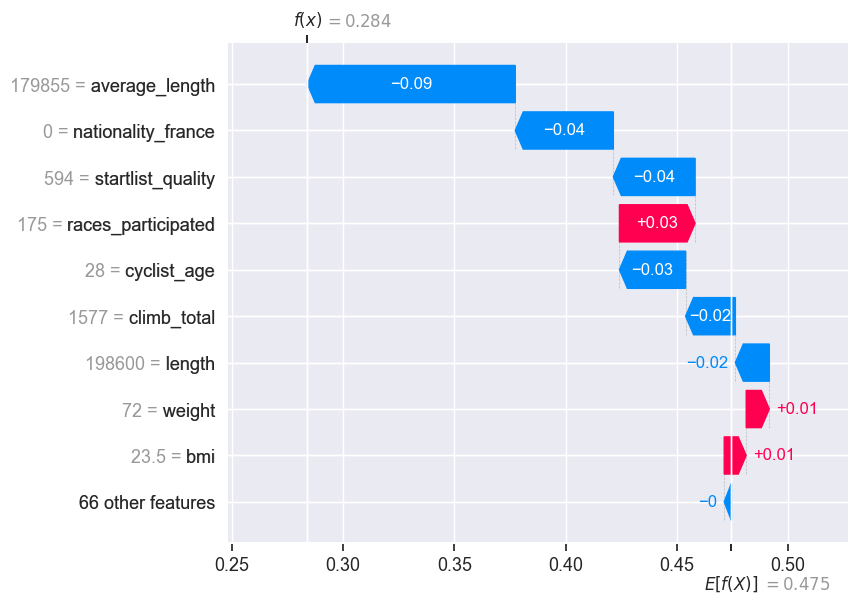

In [42]:
# Waterfall plot for the first instance and first class
shap.plots.waterfall(shap.Explanation(values=shap_explanations.values[0, :, 0], 
                                      base_values=shap_explanations.base_values[0, 0], 
                                      data=sets['validation_set'].astype('float64').iloc[0]))

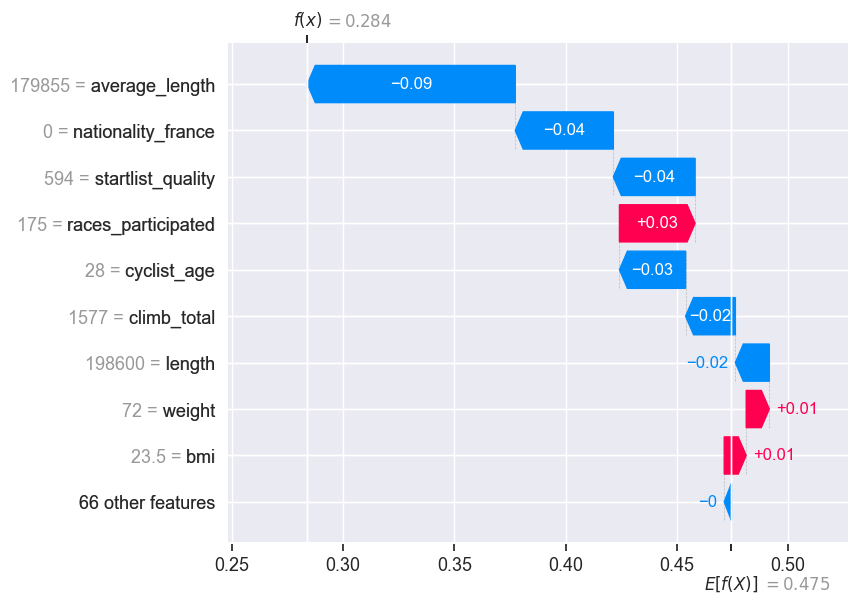

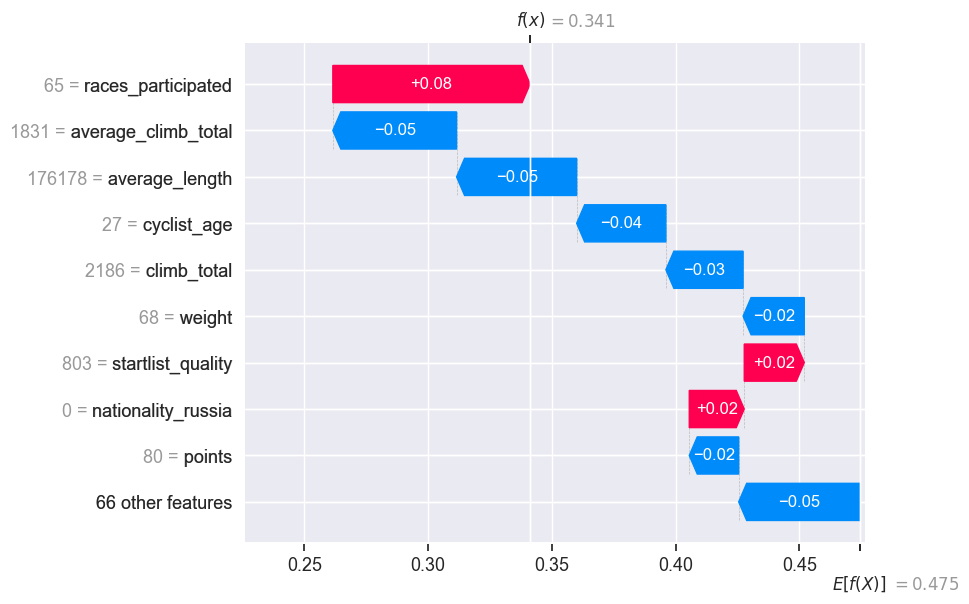

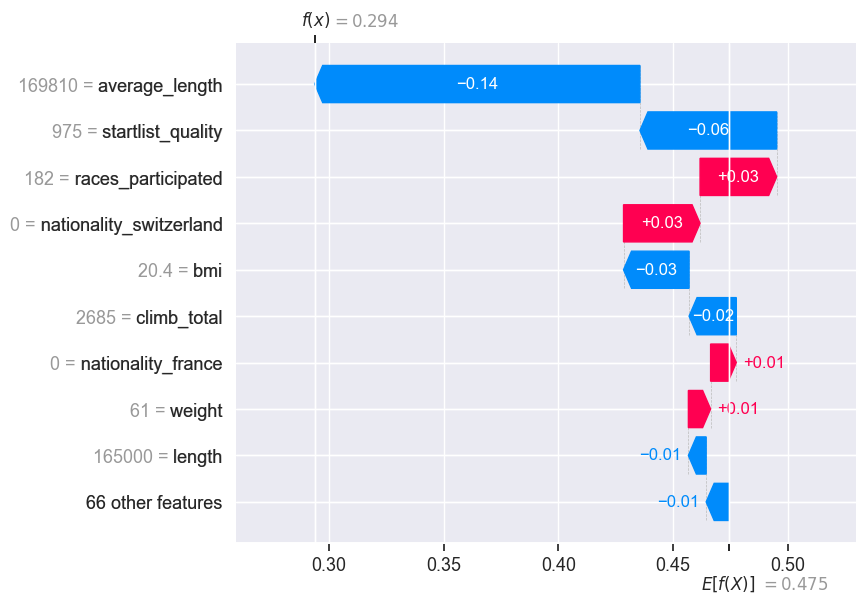

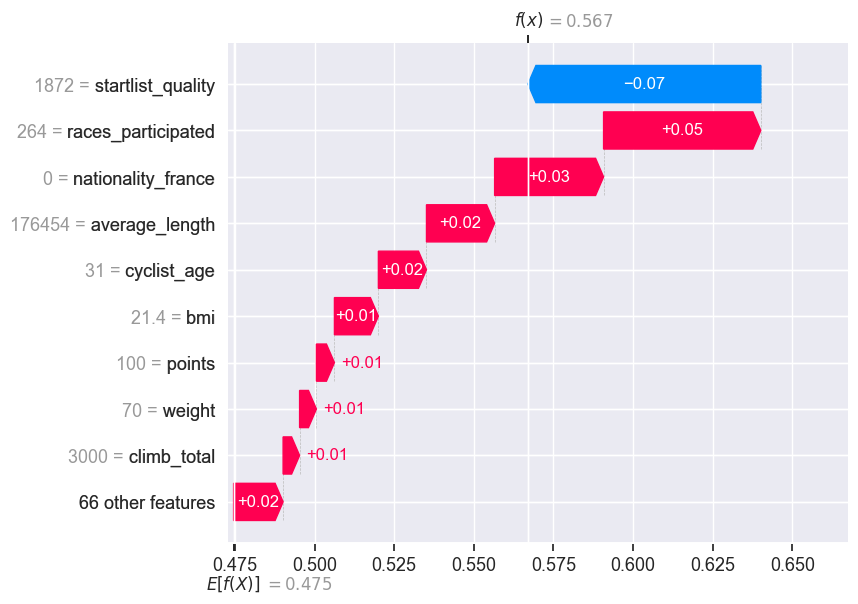

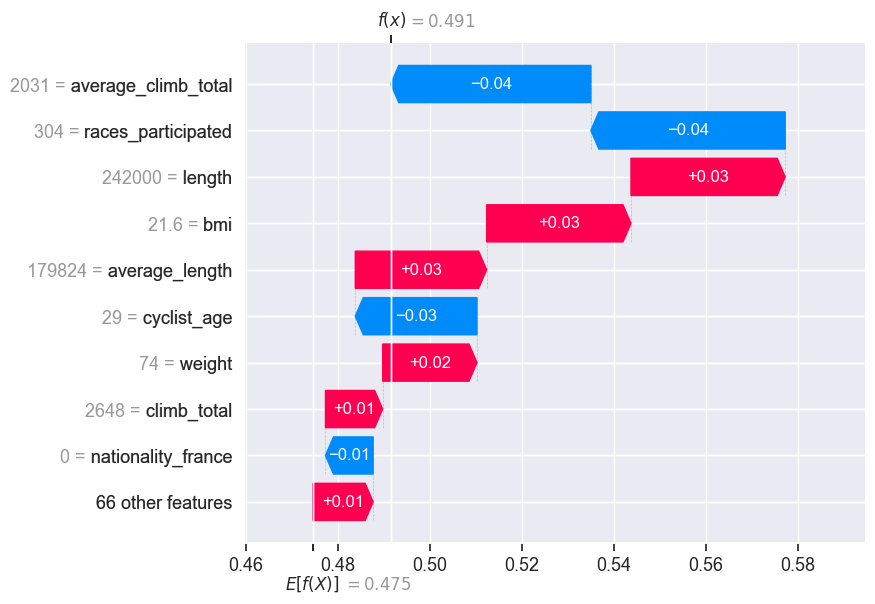

In [43]:
# Number of instances to plot
num_instances = 5  # Adjust this number as needed

# Loop through the instances and create waterfall plots
for i in range(num_instances):
    shap.plots.waterfall(shap.Explanation(values=shap_explanations.values[i, :, 0], 
                                          base_values=shap_explanations.base_values[i, 0], 
                                          data=sets['validation_set'].astype('float64').iloc[i]))
    plt.show()

# Surrogate Model for the Neural Network

In [50]:
import interpret
from tqdm import tqdm

interpret.set_visualize_provider(interpret.provider.InlineProvider())

K = 100  # Number of samples
sets['train_set_scaled_sliced'] = sets['train_set_scaled'][:K].astype('float64')
sets['validation_set_scaled_sliced'] = sets['validation_set_scaled'][:K].astype('float64')
sets['train_labels_sliced'] = sets['train_labels'][:K].astype('float64')
sets['validation_labels_sliced'] = sets['validation_labels'][:K].astype('float64')

explaination_algo = interpret.blackbox.LimeTabular(keras_model, sets['train_set_scaled_sliced'])


100%|██████████| 100/100 [00:00<00:00, 788403.01it/s]


NameError: name 'explainations' is not defined

In [51]:
LIME_explaination = np.array([np.array(e["scores"]) for e in tqdm(explaination_algo.explain_local(sets['train_set_scaled_sliced'], sets['train_labels_sliced'] )._internal_obj["specific"])])

100%|██████████| 100/100 [00:00<00:00, 892405.11it/s]


In [53]:
metric = "f1-score"
corruption_validation_lime = pd.DataFrame([
    (feature, noise_magnitude, validations_by_feature_and_noise[(feature, noise_magnitude)]["weighted avg"][metric], "lime")
    for feature, noise_magnitude in validations_by_feature_and_noise
    ],
    columns=["feature", "noise_magnitude", "performance", "algorithm"]
)
corruption_validation_lime["difference"] = corruption_validation_lime["performance"] - validation["weighted avg"][metric]

corruption_validation = pd.concat((corruption_validation, corruption_validation_lime))
corruption_validation_lime

NameError: name 'validations_by_feature_and_noise' is not defined